In [14]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platforms", "cpu")
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

import jax.numpy as jnp
from jax import Array
import numpy as np
import equinox as eqx
import matplotlib.pyplot as plt
from functools import partial

In [2]:
from xpektra import (
    SpectralSpace,
    make_field,
)
from xpektra.scheme import RotatedDifference
from xpektra.projection_operator import GalerkinProjection
from xpektra.spectral_operator import SpectralOperator
from xpektra.transform import FFTTransform
from xpektra.solvers.nonlinear import newton_krylov_solver, conjugate_gradient_while

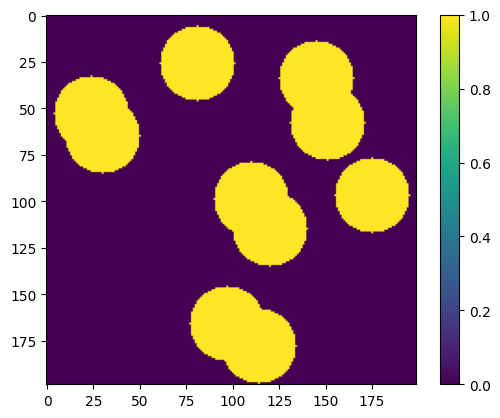

In [5]:
import random

random.seed(1)


def place_circle(matrix, n, r, x_center, y_center):
    for i in range(n):
        for j in range(n):
            if (i - x_center) ** 2 + (j - y_center) ** 2 <= r**2:
                matrix[i][j] = 1


def generate_matrix_with_circles(n, x, r):
    if r >= n:
        raise ValueError("Radius r must be less than the size of the matrix n")

    matrix = np.zeros((n, n), dtype=int)
    placed_circles = 0

    while placed_circles < x:
        x_center = random.randint(0, n - 1)
        y_center = random.randint(0, n - 1)

        # Check if the circle fits within the matrix bounds
        if (
            x_center + r < n
            and y_center + r < n
            and x_center - r >= 0
            and y_center - r >= 0
        ):
            previous_matrix = matrix.copy()
            place_circle(matrix, n, r, x_center, y_center)
            if not np.array_equal(previous_matrix, matrix):
                placed_circles += 1

    return matrix

N = 199
ndim = 2
length = 1.0

x = 10
r = 20
structure = generate_matrix_with_circles(N, x, r)


cb = plt.imshow(structure, cmap='viridis')
plt.colorbar(cb)
plt.show()

In [6]:
# Helper to map properties to grid
def map_prop(structure, val_soft, val_hard):
    return val_hard * structure + val_soft * (1 - structure)


# Properties
phase_contrast = 2.0
K_field = map_prop(structure, 0.833, phase_contrast * 0.833)
mu_field = map_prop(structure, 0.386, phase_contrast * 0.386)
H_field = map_prop(structure, 0.01, phase_contrast * 0.01)  # Normalized
sigma_y_field = map_prop(structure, 0.003, phase_contrast * 0.003)  # Normalized
n_exponent = 1.0


In [15]:
fft_transform = FFTTransform(dim=ndim)
space = SpectralSpace(lengths=(length, length), shape=(N, N), transform=fft_transform)

scheme = RotatedDifference(space=space)
op = SpectralOperator(scheme=scheme, space=space)

Ghat = GalerkinProjection(scheme=scheme)

dofs_shape = make_field(dim=ndim, shape=structure.shape, rank=2).shape

In [ ]:
# Pre-compute Identity Tensors for the grid
# I2: (N,N,2,2), I4_dev: (N,N,2,2,2,2)

i = jnp.eye(ndim)
I = make_field(dim=ndim, shape=structure.shape, rank=ndim) * i  # Broadcasted Identity
II = op.dyad(I, I)  # Fourth-order Identity

# I2 = jnp.eye(ndim) + jnp.zeros(space.shape + (ndim, ndim))  # Broadcast
# I4_sym = op.dyad(I2, I2)  # Placeholder, construct proper I4s if needed

# Or better, just implement the math directly in the material class using tensor_op

# --- 4. J2 PLASTICITY MATERIAL MODEL ---



class J2Plasticity(eqx.Module):
    """
    Encapsulates the J2 Plasticity constitutive law and return mapping.
    """

    K: jax.Array
    mu: jax.Array
    H: jax.Array
    sigma_y: jax.Array
    n: float

    def yield_stress(self, ep: jax.Array) -> jax.Array:
        return self.sigma_y + self.H * (ep**self.n)

    @eqx.filter_jit
    def compute_response(
        self, eps_total: jax.Array, state_prev: tuple[jax.Array, ...]
    ) -> tuple:
        """
        Computes stress and new state variables given total strain and history.
        state_prev = (eps_total_t, eps_elastic_t, ep_t)
        """
        eps_t, epse_t, ep_t = state_prev

        # Trial State (assume elastic step)
        # Delta eps = eps_total - eps_t
        # Trial elastic strain = old elastic strain + Delta eps
        epse_trial = epse_t + (eps_total - eps_t)
        jax.debug.print("epse_trial: {}", epse_trial.shape)

        # Volumetric / Deviatoric Split, 2D plane strain
        trace_epse = op.trace(epse_trial)
        epse_dev = epse_trial - (trace_epse[..., None, None] / 2.0) * jnp.eye(2)
 
        jax.debug.print("trace_epse: {}", epse_dev.shape)

        # Note: Be careful with 2D trace. If plane strain, tr=e11+e22.
        # If plane stress, e33 is non-zero. Assuming plane strain for simplicity.

        # Trial Stress
        # sigma_vol = K * trace_epse * I
        # sigma_dev = 2 * mu * epse_dev
        sigma_vol = self.K[..., None, None] * trace_epse[..., None, None] * jnp.eye(2)
        sigma_dev = 2.0 * self.mu[..., None, None] * epse_dev
        sigma_trial = sigma_vol + sigma_dev

        # Mises Stress
        # sig_eq = sqrt(3/2 * s:s)
        norm_s = jnp.sqrt(op.ddot(sigma_dev, sigma_dev))
        sig_eq_trial = jnp.sqrt(1.5) * norm_s

        # 2. Check Yield Condition
        sig_y_current = self.yield_stress(ep_t)
        phi = sig_eq_trial - sig_y_current

        # 3. Return Mapping (if plastic)
        # Mask for plastic points
        is_plastic = phi > 0

        # Plastic Multiplier Delta_gamma
        # Denom = 3*mu + H
        denom = 3.0 * self.mu + self.H  # (Linear hardening H' = H)
        d_gamma = jnp.where(is_plastic, phi / denom, 0.0)

        # Update State
        # Normal vector n = s_trial / |s_trial|
        # s_new = s_trial - 2*mu*d_gamma * n
        # This simplifies to scaling s_trial
        scale_factor = jnp.where(
            is_plastic, 1.0 - (3.0 * self.mu * d_gamma) / sig_eq_trial, 1.0
        )

        sigma_dev_new = sigma_dev * scale_factor[..., None, None]
        sigma_new = sigma_vol + sigma_dev_new

        # Update plastic strain
        ep_new = ep_t + d_gamma

        # Update elastic strain (back-calculate from stress)
        # eps_e_new = eps_e_trial - d_gamma * n * sqrt(3/2) ...
        # Easier: eps_e_new = C_inv : sigma_new
        # Or just update deviatoric part
        epse_dev_new = epse_dev * scale_factor[..., None, None]
        epse_vol_new = trace_epse[..., None, None] * jnp.eye(2)  # Volumetric is elastic
        epse_new = epse_dev_new + epse_vol_new

        return sigma_new, (eps_total, epse_new, ep_new)


# Instantiate Material
material = J2Plasticity(K_field, mu_field, H_field, sigma_y_field, n_exponent)

# --- 5. RESIDUAL & JACOBIAN ---


class PlasticityResidual(eqx.Module):
    material: J2Plasticity
    state_prev: tuple  # (eps_t, epse_t, ep_t)
    dofs_shape: tuple = eqx.field(static=True)

    def __call__(self, eps_total_flat):
        # Reshape
        eps_total = eps_total_flat.reshape(self.dofs_shape)

        # Compute Stress (Physics)
        # We discard the new state here, we only need stress for residual
        sigma, _ = self.material.compute_response(eps_total, self.state_prev)

        # Compute Residual (Equilibrium)
        sigma_hat = op.forward(sigma)
        res_hat = Ghat.project(sigma_hat)
        res = op.inverse(res_hat).real
        return res.reshape(-1)


class PlasticityJacobian(eqx.Module):
    residual_fn: PlasticityResidual  # Holds all necessary data

    def __call__(self, deps_flat):
        # JAX JVP does the heavy lifting!
        # It automatically linearizes the return mapping algorithm
        # to give the Consistent Algorithmic Tangent Operator.

        # We differentiate residual_fn w.r.t its input (eps_total)
        # evaluated at the current guess (which is baked into residual_fn if we used Partial,
        # but here we need the current 'eps' point).

        # ISSUE: Jacobian needs the current 'eps' point to evaluate the tangent.
        # The solver passes 'deps', assuming J(eps) * deps.
        # We need to refactor slightly to pass 'eps' into the Jacobian constructor
        # or use the 'linearize' approach in the solver.
        pass


# --- 6. MAIN SIMULATION LOOP ---

# Initialize Fields
# Layout: (N, N, 2, 2)
eps_total = make_field(dim=ndim, shape=structure.shape, rank=2)
eps_elastic = make_field(dim=ndim, shape=structure.shape, rank=2)
ep_accum = make_field(dim=ndim, shape=structure.shape, rank=0)  # Scalar plastic strain
state_current = (eps_total, eps_elastic, ep_accum)

# History storage
stress_history = []

# Load steps
n_steps = 20
max_strain = 0.02
strain_steps = jnp.linspace(0, max_strain, n_steps)

eps_macro_inc = make_field(dim=ndim, shape=structure.shape, rank=2)

print("Starting Plasticity Simulation...")

for step, eps_val in enumerate(strain_steps[1:]):
    # 1. Define Macroscopic Strain Increment
    # Pure shear loading
    delta_eps = eps_val - strain_steps[step]
    eps_macro_inc[..., 0, 1] = delta_eps
    eps_macro_inc[..., 1, 0] = delta_eps

    # Predictor (Initial Guess): eps_new = eps_old + deps_macro
    eps_guess = state_current[0] + eps_macro_inc

    # 2. Setup Solver Functions
    # We bind the *previous* state history to the residual function
    residual_fn = PlasticityResidual(material, state_current, eps_guess.shape)

    # 3. Solve Equilibrium (Newton-Krylov)
    # The solver needs a function f(x) -> b and a linear operator J(dx) -> db
    # We use jax.linearize to get the Jacobian at the current guess 'x'

    # Initial residual
    b0 = -residual_fn(eps_guess.reshape(-1))

    # Update guess
    eps_iter = eps_guess

    # Newton Loop (Manual or use xpektra solver)
    for i in range(10):  # Newton iterations
        # Linearize residual at current eps_iter
        # val is residual(eps_iter), lin_fn is the Jacobian operator J(dx)
        val, lin_fn = jax.linearize(residual_fn, eps_iter.reshape(-1))

        if jnp.linalg.norm(val) < 1e-8:
            print(f"Step {step}: Converged in {i} iterations.")
            break

        # Solve J * dx = -val using CG
        dx, _ = conjugate_gradient_while(lin_fn, -val, max_iter=50, atol=1e-5)

        # Update
        eps_iter = eps_iter + dx.reshape(eps_iter.shape)

    # 4. Update State History
    # Now we call the material one last time with the converged strain
    # to get the official new internal variables
    final_sigma, state_current = material.compute_response(eps_iter, state_current)

    # Store results
    avg_stress = jnp.mean(final_sigma, axis=(0, 1))
    stress_history.append(avg_stress[0, 1])

# Plot
plt.plot(strain_steps[1:], stress_history, "-o")
plt.xlabel("Macroscopic Shear Strain")
plt.ylabel("Macroscopic Shear Stress")
plt.title("J2 Plasticity: Stress-Strain Curve")
plt.grid()
plt.show()

Starting Plasticity Simulation...


epse_trial: (Array(199, dtype=int64), Array(199, dtype=int64), Array(2, dtype=int64), Array(2, dtype=int64))
trace_epse: (Array(199, dtype=int64), Array(199, dtype=int64), Array(2, dtype=int64), Array(2, dtype=int64))
epse_trial: (Array(199, dtype=int64), Array(199, dtype=int64), Array(2, dtype=int64), Array(2, dtype=int64))
trace_epse: (Array(199, dtype=int64), Array(199, dtype=int64), Array(2, dtype=int64), Array(2, dtype=int64))


ValueError: Non-hashable static arguments are not supported. An error occurred while trying to hash an object of type <class 'tuple'>, (((<function conjugate_gradient_while at 0x7012d45d6c00>,), PyTreeDef(*)), ((None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, TypedNdArray([[[ 0.00000000e+00 +0.j        ,
                 0.00000000e+00 +0.j        ],
               [ 0.00000000e+00 +0.j        ,
                -9.91837639e-02 +6.2821414j ],
               [ 0.00000000e+00 +0.j        ,
                -3.96636187e-01+12.55802063j],
               ...,
               [ 0.00000000e+00 +0.j        ,
                -8.92060762e-01-18.82138175j],
               [ 0.00000000e+00 +0.j        ,
                -3.96636187e-01-12.55802063j],
               [ 0.00000000e+00 +0.j        ,
                -9.91837639e-02 -6.2821414j ]],

              [[-9.91837639e-02 +6.2821414j ,
                 0.00000000e+00 +0.j        ],
               [-1.98318094e-01 +6.27901032j,
                -1.98318094e-01 +6.27901032j],
               [-2.97304170e-01 +6.27275126j,
                -5.94756593e-01+12.54863049j],
               ...,
               [ 1.98120406e-01 +6.27275126j,
                -5.94756593e-01-18.83077189j],
               [ 9.91343296e-02 +6.27901032j,
                -1.98318094e-01-12.56115172j],
               [ 1.64497329e-18 +6.2821414j ,
                -1.64497329e-18 -6.2821414j ]],

              [[-3.96636187e-01+12.55802063j,
                 0.00000000e+00 +0.j        ],
               [-5.94756593e-01+12.54863049j,
                -2.97304170e-01 +6.27275126j],
               [-7.92481820e-01+12.53299065j,
                -7.92481820e-01+12.53299065j],
               ...,
               [ 1.98120406e-01+12.54863049j,
                -2.97304170e-01-18.83077189j],
               [ 2.03607527e-17+12.55802063j,
                -2.03607527e-17-12.55802063j],
               [-1.98318094e-01+12.56115172j,
                 9.91343296e-02 -6.27901032j]],

              ...,

              [[-8.92060762e-01-18.82138175j,
                 0.00000000e+00 +0.j        ],
               [-5.94756593e-01-18.83077189j,
                 1.98120406e-01 +6.27275126j],
               [-2.97304170e-01-18.83077189j,
                 1.98120406e-01+12.54863049j],
               ...,
               [-1.78012267e+00-18.73701082j,
                -1.78012267e+00-18.73701082j],
               [-1.48503935e+00-18.77447784j,
                -9.89614772e-01-12.51111672j],
               [-1.18892032e+00-18.80261083j,
                -3.96043321e-01 -6.26337048j]],

              [[-3.96636187e-01-12.55802063j,
                 0.00000000e+00 +0.j        ],
               [-1.98318094e-01-12.56115172j,
                 9.91343296e-02 +6.27901032j],
               [ 2.03607527e-17-12.55802063j,
                -2.03607527e-17+12.55802063j],
               ...,
               [-9.89614772e-01-12.51111672j,
                -1.48503935e+00-18.77447784j],
               [-7.92481820e-01-12.53299065j,
                -7.92481820e-01-12.53299065j],
               [-5.94756593e-01-12.54863049j,
                -2.97304170e-01 -6.27275126j]],

              [[-9.91837639e-02 -6.2821414j ,
                 0.00000000e+00 +0.j        ],
               [ 1.64497329e-18 -6.2821414j ,
                -1.64497329e-18 +6.2821414j ],
               [ 9.91343296e-02 -6.27901032j,
                -1.98318094e-01+12.56115172j],
               ...,
               [-3.96043321e-01 -6.26337048j,
                -1.18892032e+00-18.80261083j],
               [-2.97304170e-01 -6.27275126j,
                -5.94756593e-01-12.54863049j],
               [-1.98318094e-01 -6.27901032j,
                -1.98318094e-01 -6.27901032j]]], dtype=complex128)), PyTreeDef(CustomNode(Partial[_HashableCallableShim(functools.partial(<function _lift_linearized at 0x7012d6518040>, let _where = { [34;1mlambda [39;22m; a[35m:bool[199,199][39m b[35m:f64[199,199][39m c[35m:f64[199,199][39m. [34;1mlet
    [39;22md[35m:f64[199,199][39m = select_n a b c
  [34;1min [39;22m(d,) } in
{ [34;1mlambda [39;22me[35m:bool[199,199,2,2][39m f[35m:f64[199,199,2,2][39m g[35m:f64[1,1,2,2][39m h[35m:f64[199,199,1,1][39m
    i[35m:f64[1,1,2,2][39m j[35m:f64[199,199,1,1][39m k[35m:f64[199,199,2,2][39m l[35m:f64[199,199][39m m[35m:f64[][39m n[35m:f64[199,199][39m
    o[35m:bool[199,199][39m p[35m:f64[199,199][39m q[35m:f64[199,199][39m r[35m:f64[199,199][39m s[35m:f64[199,199][39m t[35m:f64[199,199][39m
    u[35m:f64[199,199][39m v[35m:f64[199,199,1,1][39m w[35m:c128[199,199,2][39m x[35m:c128[199,199,2][39m; y[35m:f64[158404][39m. [34;1mlet
    [39;22mz[35m:f64[199,199,2,2][39m = reshape[
      dimensions=None
      new_sizes=(199, 199, 2, 2)
      sharding=None
    ] y
    ba[35m:f64[199,199,2,2][39m = jit[
      name=compute_response
      jaxpr={ [34;1mlambda [39;22m; e[35m:bool[199,199,2,2][39m f[35m:f64[199,199,2,2][39m g[35m:f64[1,1,2,2][39m h[35m:f64[199,199,1,1][39m
          i[35m:f64[1,1,2,2][39m j[35m:f64[199,199,1,1][39m k[35m:f64[199,199,2,2][39m l[35m:f64[199,199][39m m[35m:f64[][39m
          n[35m:f64[199,199][39m o[35m:bool[199,199][39m p[35m:f64[199,199][39m q[35m:f64[199,199][39m r[35m:f64[199,199][39m
          s[35m:f64[199,199][39m t[35m:f64[199,199][39m u[35m:f64[199,199][39m v[35m:f64[199,199,1,1][39m z[35m:f64[199,199,2,2][39m. [34;1mlet
          [39;22mbb[35m:f64[199,199][39m = jit[
            name=trace
            jaxpr={ [34;1mlambda [39;22m; e[35m:bool[199,199,2,2][39m f[35m:f64[199,199,2,2][39m z[35m:f64[199,199,2,2][39m. [34;1mlet
                [39;22mbb[35m:f64[199,199][39m = jit[
                  name=trace
                  jaxpr={ [34;1mlambda [39;22m; e[35m:bool[199,199,2,2][39m f[35m:f64[199,199,2,2][39m z[35m:f64[199,199,2,2][39m. [34;1mlet
                      [39;22mbc[35m:f64[199,199,2,2][39m = select_n e f z
                      bb[35m:f64[199,199][39m = reduce_sum[
                        axes=(2, 3)
                        out_sharding=None
                      ] bc
                    [34;1min [39;22m(bb,) }
                ] e f z
              [34;1min [39;22m(bb,) }
          ] e f z
          bd[35m:f64[199,199,1,1][39m = broadcast_in_dim[
            broadcast_dimensions=(0, 1)
            shape=(199, 199, 1, 1)
            sharding=None
          ] bb
          be[35m:f64[199,199,1,1][39m = div bd 2.0:f64[]
          bf[35m:f64[199,199,2,2][39m = mul be g
          bg[35m:f64[199,199,2,2][39m = sub z bf
          bh[35m:f64[199,199,1,1][39m = broadcast_in_dim[
            broadcast_dimensions=(0, 1)
            shape=(199, 199, 1, 1)
            sharding=None
          ] bb
          bi[35m:f64[199,199,1,1][39m = mul h bh
          bj[35m:f64[199,199,2,2][39m = mul bi i
          bk[35m:f64[199,199,2,2][39m = mul j bg
          bl[35m:f64[199,199][39m = jit[
            name=ddot
            jaxpr={ [34;1mlambda [39;22m; k[35m:f64[199,199,2,2][39m bm[35m:f64[199,199,2,2][39m bk[35m:f64[199,199,2,2][39m
                bn[35m:f64[199,199,2,2][39m. [34;1mlet
                [39;22mbl[35m:f64[199,199][39m = jit[
                  name=ddot
                  jaxpr={ [34;1mlambda [39;22m; k[35m:f64[199,199,2,2][39m bm[35m:f64[199,199,2,2][39m bk[35m:f64[199,199,2,2][39m
                      bn[35m:f64[199,199,2,2][39m. [34;1mlet
                      [39;22mbo[35m:f64[199,199][39m = dot_general[
                        dimension_numbers=(([2, 3], [3, 2]), ([0, 1], [0, 1]))
                        preferred_element_type=float64
                      ] bk k
                      bp[35m:f64[199,199][39m = dot_general[
                        dimension_numbers=(([2, 3], [3, 2]), ([0, 1], [0, 1]))
                        preferred_element_type=float64
                      ] bm bn
                      bl[35m:f64[199,199][39m = add_any bo bp
                    [34;1min [39;22m(bl,) }
                ] k bm bk bn
              [34;1min [39;22m(bl,) }
          ] k k bk bk
          bq[35m:f64[199,199][39m = mul bl l
          br[35m:f64[199,199][39m = mul m bq
          bs[35m:f64[199,199][39m = div br n
          bt[35m:f64[199,199][39m = jit[name=_where jaxpr=_where] o p bs
          bu[35m:f64[199,199][39m = mul q bt
          bv[35m:f64[199,199][39m = div bu r
          bw[35m:f64[199,199][39m = neg br
          bx[35m:f64[199,199][39m = mul bw s
          by[35m:f64[199,199][39m = mul bx t
          bz[35m:f64[199,199][39m = add_any bv by
          ca[35m:f64[199,199][39m = neg bz
          cb[35m:f64[199,199][39m = jit[name=_where jaxpr=_where] o u ca
          cc[35m:f64[199,199,1,1][39m = broadcast_in_dim[
            broadcast_dimensions=(0, 1)
            shape=(199, 199, 1, 1)
            sharding=None
          ] cb
          cd[35m:f64[199,199,2,2][39m = mul bk v
          ce[35m:f64[199,199,2,2][39m = mul k cc
          cf[35m:f64[199,199,2,2][39m = add_any cd ce
          ba[35m:f64[199,199,2,2][39m = add bj cf
        [34;1min [39;22m(ba,) }
    ] e f g h i j k l m n o p q r s t u v z
    cg[35m:c128[199,199,2,2][39m = jit[
      name=forward
      jaxpr={ [34;1mlambda [39;22m; ba[35m:f64[199,199,2,2][39m. [34;1mlet
          [39;22mcg[35m:c128[199,199,2,2][39m = jit[
            name=forward
            jaxpr={ [34;1mlambda [39;22m; ba[35m:f64[199,199,2,2][39m. [34;1mlet
                [39;22mch[35m:f64[2,2,199,199][39m = transpose[permutation=(2, 3, 0, 1)] ba
                ci[35m:c128[2,2,199,199][39m = jit[
                  name=fft
                  jaxpr={ [34;1mlambda [39;22m; ch[35m:f64[2,2,199,199][39m. [34;1mlet
                      [39;22mcj[35m:c128[2,2,199,199][39m = convert_element_type[
                        new_dtype=complex128
                        weak_type=False
                      ] ch
                      ci[35m:c128[2,2,199,199][39m = fft[
                        fft_lengths=(199, 199)
                        fft_type=0
                      ] cj
                    [34;1min [39;22m(ci,) }
                ] ch
                cg[35m:c128[199,199,2,2][39m = transpose[permutation=(2, 3, 0, 1)] ci
              [34;1min [39;22m(cg,) }
          ] ba
        [34;1min [39;22m(cg,) }
    ] ba
    ck[35m:c128[199,199,2,2][39m = jit[
      name=project
      jaxpr={ [34;1mlambda [39;22m; w[35m:c128[199,199,2][39m x[35m:c128[199,199,2][39m cg[35m:c128[199,199,2,2][39m. [34;1mlet
          [39;22mcl[35m:c128[199,199,2][39m = dot_general[
            dimension_numbers=(([2], [3]), ([0, 1], [0, 1]))
            preferred_element_type=complex128
          ] w cg
          ck[35m:c128[199,199,2,2][39m = dot_general[
            dimension_numbers=(([], []), ([0, 1], [0, 1]))
            preferred_element_type=complex128
          ] cl x
        [34;1min [39;22m(ck,) }
    ] w x cg
    cm[35m:f64[199,199,2,2][39m = jit[
      name=inverse
      jaxpr={ [34;1mlambda [39;22m; ck[35m:c128[199,199,2,2][39m. [34;1mlet
          [39;22mcn[35m:c128[199,199,2,2][39m = jit[
            name=inverse
            jaxpr={ [34;1mlambda [39;22m; ck[35m:c128[199,199,2,2][39m. [34;1mlet
                [39;22mco[35m:c128[2,2,199,199][39m = transpose[permutation=(2, 3, 0, 1)] ck
                cp[35m:c128[2,2,199,199][39m = jit[
                  name=fft
                  jaxpr={ [34;1mlambda [39;22m; co[35m:c128[2,2,199,199][39m. [34;1mlet
                      [39;22mcp[35m:c128[2,2,199,199][39m = fft[
                        fft_lengths=(199, 199)
                        fft_type=1
                      ] co
                    [34;1min [39;22m(cp,) }
                ] co
                cn[35m:c128[199,199,2,2][39m = transpose[permutation=(2, 3, 0, 1)] cp
              [34;1min [39;22m(cn,) }
          ] ck
          cm[35m:f64[199,199,2,2][39m = real cn
        [34;1min [39;22m(cm,) }
    ] ck
    cq[35m:f64[158404][39m = reshape[dimensions=None new_sizes=(158404,) sharding=None] cm
  [34;1min [39;22m(cq,) }, [ShapedArray(float64[158404])], (PyTreeDef((*,)), PyTreeDef(*)), [(ShapedArray(float64[158404]), None)]))], [([*, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *, *],), {}]))), ((None, 1e-05, 50), PyTreeDef(((*, *, *, None), {})))). The error was:
TypeError: unhashable type: 'TypedNdArray'


In [18]:
ep_accum.shape

(199, 199, 2)

In [1]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
import jax.numpy as jnp
import numpy as np

In [2]:
from functools import partial

import matplotlib.pyplot as plt
from skimage.morphology import disk, ellipse, rectangle
from spectralsolver import (
    DifferentialMode,
    SpectralSpace,
    TensorOperator,
    make_field,
)
from spectralsolver.operators import fourier_galerkin
from typing import Callable

In this notebook, we implement the small-strain `J2` plasticity. We use the automatic differentiation to compute the alogriothmic tangent stiffness matrix (which ia function of bbothe elastic strain and plastic strain and yield function). It is necessary for `Newton-Raphson` iteration. 

## constructing an RVE

In [3]:
import random

random.seed(1)


def place_circle(matrix, n, r, x_center, y_center):
    for i in range(n):
        for j in range(n):
            if (i - x_center) ** 2 + (j - y_center) ** 2 <= r**2:
                matrix[i][j] = 1


def generate_matrix_with_circles(n, x, r):
    if r >= n:
        raise ValueError("Radius r must be less than the size of the matrix n")

    matrix = np.zeros((n, n), dtype=int)
    placed_circles = 0

    while placed_circles < x:
        x_center = random.randint(0, n - 1)
        y_center = random.randint(0, n - 1)

        # Check if the circle fits within the matrix bounds
        if (
            x_center + r < n
            and y_center + r < n
            and x_center - r >= 0
            and y_center - r >= 0
        ):
            previous_matrix = matrix.copy()
            place_circle(matrix, n, r, x_center, y_center)
            if not np.array_equal(previous_matrix, matrix):
                placed_circles += 1

    return matrix


# Example usage
N = 199
shape = (N, N)
length = 1.0
ndim = 2


x = 10
r = 20
structure = generate_matrix_with_circles(N, x, r)

In [4]:
grid_size = (N,) * ndim
elasticity_dof_shape = (ndim, ndim) + grid_size

## assigning material parameters 
We assign material parameters to the two phases. The two phases within the RVE are denoted as
- Soft = 0
- Hard = 1

In [5]:
# material parameters + function to convert to grid of scalars
def param(X, soft, hard):
    return hard * jnp.ones_like(X) * (X) + soft * jnp.ones_like(X) * (1 - X)

We consider a `linear isotropic hardening law` for both the phases

In [6]:
# material parameters
phase_constrast = 2

K = param(structure, soft=0.833, hard=phase_constrast * 0.833)  # bulk      modulus
μ = param(structure, soft=0.386, hard=phase_constrast * 0.386)  # shear     modulus
H = param(
    structure, soft=2000.0e6 / 200.0e9, hard=phase_constrast * 2000.0e6 / 200.0e9
)  # hardening modulus
sigma_y = param(
    structure, soft=600.0e6 / 200.0e9, hard=phase_constrast * 600.0e6 / 200.0e9
)  # initial yield stress

n = 1.0

## plasticity basics

Now we define the basics of plasticity implementation:

- yield surface

$$
\Phi(\sigma_{ij}, \varepsilon^p_{ij}) = \underbrace{\sqrt{\dfrac{3}{2}\sigma^{dev}_{ij}\sigma^{dev}_{jk}}}_{\sigma^{eq}} - (\sigma_{0} + H\varepsilon^{p})
$$

- return mappping algorithm

$$
\Delta \varepsilon =  \dfrac{\langle \Phi(\sigma_{ij}, \varepsilon_{p}) \rangle_{+}}{3\mu + H}
$$

- tangent stiffness operator
  
$$
\mathbb{C} = \dfrac{\partial \sigma^{t+1}}{\partial \varepsilon^{t+1}} 
$$

We also define certain Identity tensor for each grid point.

- $\mathbf{I}$ = 2 order Identity tensor with shape `(2, 2, N, N)` 
- $\mathbb{I4}$ = 4 order Identity tensor with shape `(2, 2, 2, 2, N, N)`


In [7]:
tensor = TensorOperator(dim=ndim)
space = SpectralSpace(size=N, dim=ndim, length=length)

In [8]:
# identity tensor (single tensor)
i = jnp.eye(ndim)

# identity tensors (grid)
I = jnp.einsum(
    "ij,xy",
    i,
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)  # 2nd order Identity tensor
I4 = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("il,jk", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)  # 4th order Identity tensor
I4rt = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("ik,jl", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)
I4s = (I4 + I4rt) / 2.0

II = tensor.dyad(I, I)
I4d = I4s - II / 3.0

Ghat = fourier_galerkin.compute_projection_operator(
    space=space, diff_mode=DifferentialMode.rotated_difference
)

In [9]:
import equinox as eqx

In [10]:
@jax.jit
def yield_function(ep: jnp.ndarray):
    return sigma_y + H * ep**n


@jax.jit
def compute_stress(eps: jnp.ndarray, args: tuple):
    eps_t, epse_t, ep_t = args

    # elastic stiffness tensor
    C4e = K * II + 2.0 * μ * I4d

    # trial state
    epse_s = epse_t + (eps - eps_t)
    sig_s = tensor.ddot(C4e, epse_s)
    sigm_s = tensor.ddot(sig_s, I) / 3.0
    sigd_s = sig_s - sigm_s * I
    sigeq_s = jnp.sqrt(3.0 / 2.0 * tensor.ddot(sigd_s, sigd_s))

    # avoid zero division below ("phi_s" is corrected below)
    Z = jnp.where(sigeq_s == 0, True, False)
    sigeq_s = jnp.where(Z, 1, sigeq_s)

    # evaluate yield surface, set to zero if elastic (or stress-free)
    sigy = yield_function(ep_t)
    phi_s = sigeq_s - sigy
    phi_s = 1.0 / 2.0 * (phi_s + jnp.abs(phi_s))
    phi_s = jnp.where(Z, 0.0, phi_s)
    elastic_pt = jnp.where(phi_s <= 0, True, False)

    # plastic multiplier, based on non-linear hardening
    # - initialize
    dep = phi_s / (3 * μ + H)

    # return map algorithm
    N = 3.0 / 2.0 * sigd_s / sigeq_s
    ep = ep_t + dep
    sig = sig_s - dep * N * 2.0 * μ
    epse = epse_s - dep * N

    return sig, epse, ep


@eqx.filter_jit
def compute_residual(sigma: jnp.ndarray) -> jnp.ndarray:
    return jnp.real(space.ifft(tensor.ddot(Ghat, space.fft(sigma)))).reshape(-1)


@eqx.filter_jit
def compute_tangents(deps: jnp.ndarray, args: tuple):
    deps = deps.reshape(ndim, ndim, N, N)
    eps, eps_t, epse_t, ep_t = args
    primal, tangents = jax.jvp(
        partial(compute_stress, args=(eps_t, epse_t, ep_t)), (eps,), (deps,)
    )
    return compute_residual(tangents[0])


# partial_compute_tangent = partial(compute_tangents, sigma=sigma)

In [11]:
from spectralsolver.solvers.nonlinear import (
    conjugate_gradient_while,
    newton_krylov_solver,
)

In [12]:
@jax.jit
def newton_solver(state, n):
    deps, b, eps, eps_t, epse_t, ep_t, En, sig = state

    error = jnp.linalg.norm(deps) / En
    jax.debug.print("residual={}", jnp.linalg.norm(deps) / En)

    def true_fun(state):
        deps, b, eps, eps_t, epse_t, ep_t, En, sig = state

        partial_compute_tangent = jax.jit(
            partial(compute_tangents, args=(eps, eps_t, epse_t, ep_t))
        )

        deps, iiter = conjugate_gradient_while(
            atol=1e-8,
            A=partial_compute_tangent,
            b=b,
        )  # solve linear system using CG

        deps = deps.reshape(eps.shape)
        eps = jax.lax.add(eps, deps)  # update DOFs (array -> tensor.grid)
        sig, epse, ep = compute_stress(eps, (eps_t, epse_t, ep_t))
        b = -compute_residual(sig)  # compute residual

        jax.debug.print("CG iteration {}", iiter)

        return (deps, b, eps, eps_t, epse, ep, En, sig)

    def false_fun(state):
        return state

    return jax.lax.cond(error > 1e-8, true_fun, false_fun, state), n

In [13]:
# initialize: stress and strain tensor, and history
sig = make_field(dim=ndim, N=N, rank=2)
eps = make_field(dim=ndim, N=N, rank=2)
eps_t = make_field(dim=ndim, N=N, rank=2)
epse_t = make_field(dim=ndim, N=N, rank=2)
ep_t = make_field(dim=ndim, N=N, rank=2)
deps = make_field(dim=ndim, N=N, rank=2)

# define incremental macroscopic strain
ninc = 100
epsbar = 0.12
deps[0, 0] = jnp.sqrt(3.0) / 2.0 * epsbar / float(ninc)
deps[1, 1] = -jnp.sqrt(3.0) / 2.0 * epsbar / float(ninc)

b = -compute_tangents(deps, (eps, eps_t, epse_t, ep_t))
eps = jax.lax.add(eps, deps)
En = jnp.linalg.norm(eps)

In [14]:
state = (deps, b, eps, eps_t, epse_t, ep_t, En, sig)
final_state, xs = jax.lax.scan(newton_solver, init=state, xs=jnp.arange(0, 10))

residual=1.0
CG iteration 18
residual=0.30347510072366196
CG iteration 0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
